In [55]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support, roc_auc_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, roc_curve, auc
from transformers import DistilBertTokenizer, DistilBertModel
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight


## Loading data

In [57]:
data = pd.read_csv("hf://datasets/dirtycomputer/Automated_Hate_Speech_Detection_and_the_Problem_of_Offensive_Language/labeled_data.csv")

data.sample(5)

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
2079,2122,3,0,3,0,1,' Ma niggah Alsina be doin his thang . http://...
7245,7452,3,0,3,0,1,@valeriemaria2 @assholee813 bitch wea ur clothes
14354,14697,3,0,0,3,2,RT @BestOfWorldStar: Charlie Sheen did the ice...
22030,22497,3,1,0,2,2,This dumb Berk drives in circles through town ...
8673,8914,3,0,1,2,2,"Dear God, forgive us for a moral slope of valu..."


In [58]:
data.shape

(24783, 7)

## Data Processesing

In [59]:
# Text processing functions
def clean_text(text):
    text = re.sub(r'@\w+', '', text)  # Remove username
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # Keep alphabets
    text = text.lower()
    return text

# Apply the clean_comment function to the tweet column
data['processed_tweet'] = data['tweet'].apply(clean_text)

data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,processed_tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,rt as a woman you shouldn t complain abo...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,rt boy dats cold tyga dwn bad for cu...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,rt dawg rt you ever fuck a bitc...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,rt she look like a tranny
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,rt the shit you hear about me ...


## Splitting Data for Training and Testing


In [60]:
X = data['processed_tweet']
y = data['class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((19826,), (4957,), (19826,), (4957,))

## Initializing BERT Tokenizer

In [47]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')


## Creating Dataset Class

In [48]:
class ToxicCommentsDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):

        text = self.texts[idx]
        if not isinstance(text, str):
          text = str(text)
        inputs = tokenizer(text, padding='max_length', max_length=64, truncation=True, return_tensors="pt")
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return inputs['input_ids'].squeeze(), inputs['attention_mask'].squeeze(), label

### Wrapping training and test data in PyTorch Dataset objects.


In [61]:
train_dataset = ToxicCommentsDataset(X_train.tolist(), y_train)
test_dataset = ToxicCommentsDataset(X_test.tolist(), y_test)

### Preparing DataLoaders for efficient batch processing.

In [62]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

## Defining Toxic Comment Classifier



In [51]:
import torch
import torch.nn as nn
from transformers import DistilBertModel

class ToxicCommentClassifier(nn.Module):
    def __init__(self):
        super(ToxicCommentClassifier, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')

        # Unfreeze the last few layers of DistilBERT
        for name, param in self.distilbert.named_parameters():
            if "transformer.layer.4" in name or "transformer.layer.5" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

        self.fc_1 = nn.Linear(768, 512)
        self.fc_2 = nn.Linear(512, 128)
        self.fc_3 = nn.Linear(128, 3)  # Output for 3 classes

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.layer_norm = nn.LayerNorm(512)

    def forward(self, input_ids, attention_mask):
        # Pass through DistilBERT
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # Extract [CLS] token output

        out = self.fc_1(cls_output)
        out = self.layer_norm(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.fc_2(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.fc_3(out)
        return out



## Model Setup

In [70]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ToxicCommentClassifier().to(device)
print(device)

cuda


In [71]:
# criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# Initialize the learning rate scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.6)  # Reduce LR by 10% every 5 epochs


### To balance class

In [72]:
# Compute class weights automatically
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print(class_weights)
criterion = nn.CrossEntropyLoss(weight=class_weights)

tensor([5.7971, 0.4303, 1.9858], device='cuda:0')


## Training Loop

In [73]:


# Path to save the model
save_path = "best_model.pth"


for epoch in range(20):
    # Training phase
    model.train()
    total_loss = 0
    with tqdm(train_loader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch + 1} - Training")
        for input_ids, attention_mask, labels in tepoch:
            input_ids, attention_mask, labels = (
                input_ids.to(device),
                attention_mask.to(device),
                labels.to(device),
            )

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            tepoch.set_postfix(loss=loss.item())

    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss}")

    # Save model if training loss <= 0.3
    if avg_train_loss <= 0.3:
        print(f"Training Loss < 0.3. Saving model at epoch {epoch + 1}...")
        torch.save(model.state_dict(), save_path)

    model.eval()
    val_loss = 0
    y_pred, y_true = [], []
    with tqdm(test_loader, unit="batch") as vepoch:
        vepoch.set_description(f"Epoch {epoch + 1} - Validation")
        with torch.no_grad():
            for input_ids, attention_mask, labels in vepoch:
                input_ids, attention_mask, labels = (
                    input_ids.to(device),
                    attention_mask.to(device),
                    labels.to(device),
                )
                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, dim=1)
                y_pred.extend(preds.cpu().numpy())
                y_true.extend(labels.cpu().numpy())

                vepoch.set_postfix(loss=loss.item())

    val_loss /= len(test_loader)
    accuracy = sum(1 for x, y in zip(y_pred, y_true) if x == y) / len(y_true)

    print(f"Epoch {epoch + 1}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.2f}")

    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]
    print(f"Epoch {epoch + 1}, Learning Rate: {current_lr}")



Epoch 1 - Training: 100%|██████████| 620/620 [01:04<00:00,  9.57batch/s, loss=0.358]


Epoch 1, Training Loss: 0.5736798836098563


Epoch 1 - Validation: 100%|██████████| 155/155 [00:10<00:00, 15.21batch/s, loss=0.489]


Epoch 1, Validation Loss: 0.4569, Validation Accuracy: 0.87
Epoch 1, Learning Rate: 0.0001


Epoch 2 - Training: 100%|██████████| 620/620 [01:04<00:00,  9.57batch/s, loss=0.155]


Epoch 2, Training Loss: 0.42959944030209896


Epoch 2 - Validation: 100%|██████████| 155/155 [00:10<00:00, 14.90batch/s, loss=0.443]


Epoch 2, Validation Loss: 0.4466, Validation Accuracy: 0.83
Epoch 2, Learning Rate: 0.0001


Epoch 3 - Training: 100%|██████████| 620/620 [01:03<00:00,  9.69batch/s, loss=0.249]


Epoch 3, Training Loss: 0.3786730428857188


Epoch 3 - Validation: 100%|██████████| 155/155 [00:10<00:00, 15.30batch/s, loss=0.517]


Epoch 3, Validation Loss: 0.4721, Validation Accuracy: 0.87
Epoch 3, Learning Rate: 0.0001


Epoch 4 - Training: 100%|██████████| 620/620 [01:04<00:00,  9.64batch/s, loss=0.225]


Epoch 4, Training Loss: 0.34061568162494127


Epoch 4 - Validation: 100%|██████████| 155/155 [00:10<00:00, 15.05batch/s, loss=0.373]


Epoch 4, Validation Loss: 0.4951, Validation Accuracy: 0.82
Epoch 4, Learning Rate: 0.0001


Epoch 5 - Training: 100%|██████████| 620/620 [01:03<00:00,  9.70batch/s, loss=0.404]


Epoch 5, Training Loss: 0.2863106696926538
Training Loss < 0.3. Saving model at epoch 5...


Epoch 5 - Validation: 100%|██████████| 155/155 [00:10<00:00, 15.07batch/s, loss=0.493]


Epoch 5, Validation Loss: 0.5290, Validation Accuracy: 0.89
Epoch 5, Learning Rate: 6e-05


Epoch 6 - Training: 100%|██████████| 620/620 [01:04<00:00,  9.67batch/s, loss=0.174]


Epoch 6, Training Loss: 0.2234440285231798
Training Loss < 0.3. Saving model at epoch 6...


Epoch 6 - Validation: 100%|██████████| 155/155 [00:10<00:00, 15.08batch/s, loss=0.402]


Epoch 6, Validation Loss: 0.5703, Validation Accuracy: 0.82
Epoch 6, Learning Rate: 6e-05


Epoch 7 - Training: 100%|██████████| 620/620 [01:03<00:00,  9.69batch/s, loss=0.267]


Epoch 7, Training Loss: 0.19138965993638962
Training Loss < 0.3. Saving model at epoch 7...


Epoch 7 - Validation: 100%|██████████| 155/155 [00:10<00:00, 15.09batch/s, loss=0.597]


Epoch 7, Validation Loss: 0.6587, Validation Accuracy: 0.87
Epoch 7, Learning Rate: 6e-05


Epoch 8 - Training:   6%|▌         | 36/620 [00:03<01:00,  9.72batch/s, loss=0.0696]


KeyboardInterrupt: 

In [ ]:
# logs
"""
Epoch 1 - Training: 100%|██████████| 620/620 [01:05<00:00,  9.41batch/s, loss=0.115]
Epoch 1, Training Loss: 0.3114450721190341
Epoch 1 - Validation: 100%|██████████| 155/155 [00:10<00:00, 15.21batch/s, loss=0.19]
Epoch 1, Validation Loss: 0.2621, Validation Accuracy: 0.91
Epoch 1, Learning Rate: 0.0001
Epoch 2 - Training: 100%|██████████| 620/620 [01:04<00:00,  9.68batch/s, loss=0.201]
Epoch 2, Training Loss: 0.24053236350056625
Training Loss < 0.3. Saving model at epoch 2...
Epoch 2 - Validation: 100%|██████████| 155/155 [00:10<00:00, 14.64batch/s, loss=0.222]
Epoch 2, Validation Loss: 0.2414, Validation Accuracy: 0.92
Epoch 2, Learning Rate: 0.0001
Epoch 3 - Training: 100%|██████████| 620/620 [01:04<00:00,  9.61batch/s, loss=0.219]
Epoch 3, Training Loss: 0.2172438312261816
Training Loss < 0.3. Saving model at epoch 3...
Epoch 3 - Validation: 100%|██████████| 155/155 [00:10<00:00, 14.97batch/s, loss=0.18]
Epoch 3, Validation Loss: 0.2585, Validation Accuracy: 0.90
Epoch 3, Learning Rate: 0.0001
Epoch 4 - Training: 100%|██████████| 620/620 [01:06<00:00,  9.33batch/s, loss=0.751]
Epoch 4, Training Loss: 0.19502148372872222
Training Loss < 0.3. Saving model at epoch 4...
Epoch 4 - Validation: 100%|██████████| 155/155 [00:10<00:00, 14.95batch/s, loss=0.213]
Epoch 4, Validation Loss: 0.2743, Validation Accuracy: 0.91
Epoch 4, Learning Rate: 0.0001
Epoch 5 - Training: 100%|██████████| 620/620 [01:04<00:00,  9.62batch/s, loss=0.084]
Epoch 5, Training Loss: 0.17181494032904024
Training Loss < 0.3. Saving model at epoch 5...
Epoch 5 - Validation: 100%|██████████| 155/155 [00:10<00:00, 14.94batch/s, loss=0.163]
Epoch 5, Validation Loss: 0.2865, Validation Accuracy: 0.89
Epoch 5, Learning Rate: 6e-05
Epoch 6 - Training: 100%|██████████| 620/620 [01:04<00:00,  9.65batch/s, loss=0.27]
Epoch 6, Training Loss: 0.13215160482533037
Training Loss < 0.3. Saving model at epoch 6...
Epoch 6 - Validation:  31%|███       | 48/155 [00:03<00:07, 15.14batch/s, loss=0.12]



"""


## Evaluation

In [74]:
# Evaluation
model.eval()
y_pred, y_true = [], []
y_prob = []
with torch.no_grad():
    for input_ids, attention_mask, labels in test_loader:
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        outputs = model(input_ids, attention_mask)
        _, preds = torch.max(outputs, dim=1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

        y_prob.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())

In [75]:
accuracy = accuracy_score(y_true, y_pred)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.880371192253379


In [76]:
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
roc_auc = roc_auc_score(
    y_true,
    torch.nn.functional.one_hot(torch.tensor(y_pred), num_classes=3).numpy(),
    multi_class='ovr'
)

print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("ROC-AUC Score:", roc_auc)

Precision: 0.9067947181911077
Recall: 0.880371192253379
F1-Score: 0.8907129061177822
ROC-AUC Score: 0.8627839103981348


In [77]:
# Classification report
print("\nClassification Report:\n")
class_names = ['Hate', 'Offensive', 'Neutral']
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:

              precision    recall  f1-score   support

        Hate       0.36      0.63      0.46       290
   Offensive       0.96      0.90      0.93      3832
     Neutral       0.86      0.88      0.87       835

    accuracy                           0.88      4957
   macro avg       0.73      0.80      0.75      4957
weighted avg       0.91      0.88      0.89      4957



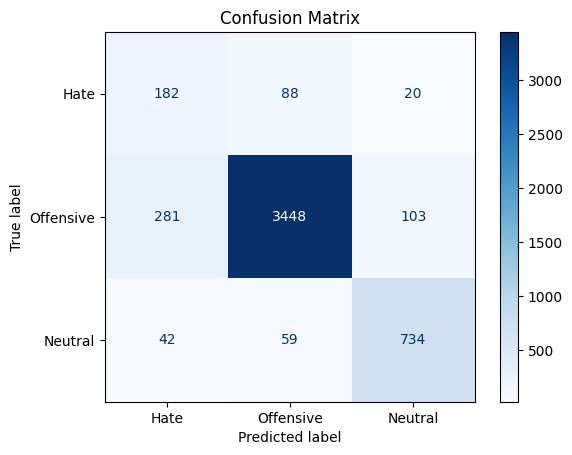

In [78]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ['Hate', 'Offensive', 'Neutral']

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

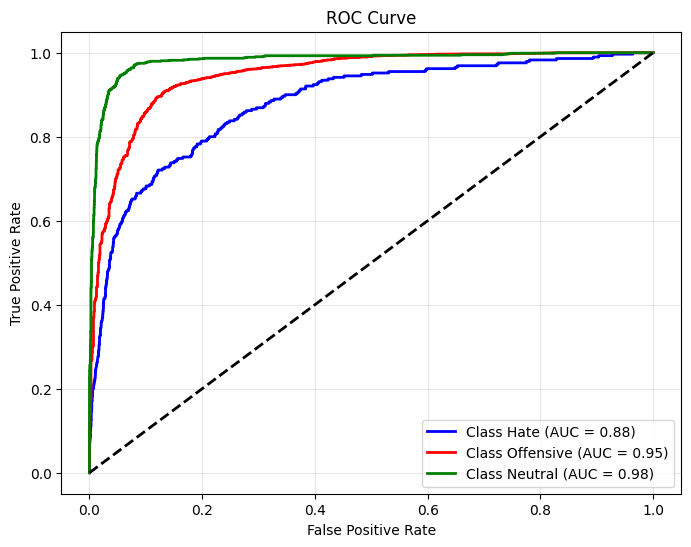

In [79]:
y_prob = np.array(y_prob)
y_true_binarized = label_binarize(y_true, classes=[0, 1, 2])  # 0: Hate, 1: Offensive, 2: Neutral
n_classes = y_true_binarized.shape[1]


# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green']
class_names = ['Hate', 'Offensive', 'Neutral']

for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Add labels and legend
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

## Final Prediction Function

In [80]:
# Prediction function

def predict_toxicity(comment):
    model.eval()
    inputs = tokenizer(comment, padding='max_length', max_length=128, truncation=True, return_tensors="pt")
    input_ids, attention_mask = inputs['input_ids'].to(device), inputs['attention_mask'].to(device)

    with torch.no_grad():
        output = model(input_ids, attention_mask)
        _, prediction = torch.max(output, dim=1)

    if prediction.item() == 0:
        return 'Hate'
    elif prediction.item() == 1:
        return 'Offensive'
    else:
        return 'Neutral'


In [81]:
# Example prediction
comment = "It is raining in Mumbai"
print("Prediction:", predict_toxicity(comment))

Prediction: Neutral


In [ ]:
# Save the trained model
# torch.save(model.state_dict(), "toxic_comment_model.pth")